In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as st
import statsmodels as sm
import matplotlib.patches as mpatches

%matplotlib inline
plt.style.use('ggplot')

### Let's import the data and take a look at its statistics first

In [61]:
response_df = pd.read_csv('response_data.csv')
response_df.head()

,Driver Response Timestamp,Order Create Timestamp,Order Id
0,3/24/17 22:58:31,3/24/17 22:57:38,1
1,3/25/17 1:04:53,3/25/17 1:04:53,2
2,3/25/17 1:06:16,3/25/17 1:06:16,3
3,3/25/17 1:08:40,3/25/17 1:07:03,4
4,3/25/17 2:34:18,3/25/17 2:34:08,5


In [62]:
# Information about the dataset
response_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Driver Response Timestamp  5000 non-null   object
 1   Order Create Timestamp     5000 non-null   object
 2   Order Id                   5000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


#### There are no null values in the dataset. This is good because we won't need to clean it.

#### We will now create some additional variables from the original dataset for better analysis

In [63]:
# First we change the format of the response time and create time fields to datetime format

response_df['Driver Response Timestamp'] = pd.to_datetime(response_df['Driver Response Timestamp'])
response_df['Order Create Timestamp'] = pd.to_datetime(response_df['Order Create Timestamp'])

# We will create variables for duration of response from driver and order time
response_df['Duration'] = response_df['Driver Response Timestamp'] - response_df['Order Create Timestamp']
response_df['Duration'] = response_df['Duration'].dt.total_seconds()

response_df['Duration in mins'] = response_df['Duration']/60.0

# We will create variables for hours, day and day of the week for order placed time
response_df['Order hour'] = response_df['Order Create Timestamp'].dt.hour
response_df['Order day'] = response_df['Order Create Timestamp'].dt.day
response_df['Order day of week'] = response_df['Order Create Timestamp'].dt.weekday

In [64]:
response_df.head(5)

,Driver Response Timestamp,Order Create Timestamp,Order Id,Duration,Duration in mins,Order hour,Order day,Order day of week
0,2017-03-24 22:58:31,2017-03-24 22:57:38,1,53.0,0.883333,22,24,4
1,2017-03-25 01:04:53,2017-03-25 01:04:53,2,0.0,0.000000,1,25,5
2,2017-03-25 01:06:16,2017-03-25 01:06:16,3,0.0,0.000000,1,25,5
3,2017-03-25 01:08:40,2017-03-25 01:07:03,4,97.0,1.616667,1,25,5
4,2017-03-25 02:34:18,2017-03-25 02:34:08,5,10.0,0.166667,2,25,5


#### We will now get the basic statistical information from the dataset

In [65]:
response_df[['Duration','Duration in mins']].describe()

,Duration,Duration in mins
count,5000.000000,5000.000000
mean,48.891200,0.814853
std,212.811331,3.546856
min,0.000000,0.000000
25%,9.000000,0.150000
50%,12.000000,0.200000
75%,26.000000,0.433333
max,4102.000000,68.366667


#### The mean of the order matching time is 48.89 seconds and the median is 12 seconds.

#### Now we will seperate the records based on the implementation of new system at 2017-03-30 12:00 AM

In [66]:
# We create a dataframe with responses berfore the change
response_prior = response_df[response_df['Order Create Timestamp'] < pd.to_datetime('2017-03-30 00:00:00')]

# We create a dataframe with the responses after the change
response_post = response_df[response_df['Order Create Timestamp'] > pd.to_datetime('2017-03-30 00:00:00')]

In [67]:
# Checking the last values before the change was implemented
response_prior.tail(5)

,Driver Response Timestamp,Order Create Timestamp,Order Id,Duration,Duration in mins,Order hour,Order day,Order day of week
2593,2017-03-29 18:27:04,2017-03-29 18:26:56,2594,8.0,0.133333,18,29,2
2594,2017-03-29 18:27:15,2017-03-29 18:27:07,2595,8.0,0.133333,18,29,2
2595,2017-03-29 18:32:30,2017-03-29 18:32:22,2596,8.0,0.133333,18,29,2
2596,2017-03-29 18:44:05,2017-03-29 18:43:51,2597,14.0,0.233333,18,29,2
2597,2017-03-29 19:05:43,2017-03-29 19:05:35,2598,8.0,0.133333,19,29,2


In [68]:
# Checking the first values after the change was implemented
response_post.head(5)

,Driver Response Timestamp,Order Create Timestamp,Order Id,Duration,Duration in mins,Order hour,Order day,Order day of week
2598,2017-03-30 02:33:33,2017-03-30 02:32:35,2599,58.0,0.966667,2,30,3
2599,2017-03-30 02:40:47,2017-03-30 02:40:13,2600,34.0,0.566667,2,30,3
2600,2017-03-30 02:45:19,2017-03-30 02:44:01,2601,78.0,1.300000,2,30,3
2601,2017-03-30 02:56:25,2017-03-30 02:55:51,2602,34.0,0.566667,2,30,3
2602,2017-03-30 03:05:39,2017-03-30 03:03:45,2603,114.0,1.900000,3,30,3


In [69]:
# Lets check the total number of records before the change
response_prior.shape

(2598, 8)

In [70]:
# Lets check the total number of records after the change
response_post.shape

(2402, 8)

## Question1) What is the resulting impact from the change?

In [71]:
# Let's get the statistical information for the duration for both prior and post set of records
extract = ['Duration','Duration in mins']

response_prior[extract].describe()

,Duration,Duration in mins
count,2598.000000,2598.000000
mean,47.854888,0.797581
std,216.946677,3.615778
min,0.000000,0.000000
25%,9.000000,0.150000
50%,12.500000,0.208333
75%,25.000000,0.416667
max,4102.000000,68.366667


In [72]:
response_post[extract].describe()

,Duration,Duration in mins
count,2402.000000,2402.000000
mean,50.012073,0.833535
std,208.285455,3.471424
min,0.000000,0.000000
25%,9.000000,0.150000
50%,11.000000,0.183333
75%,26.000000,0.433333
max,3945.000000,65.750000


#### We see an improvement in standard deviation (208 seconds from 216 seconds), median (11 seconds from 12.5 seconds) and max wait time (3945 seconds from 4102 seconds). However the mean has increased (50.01 seconds from 47.85 seconds). This suggests that there might be more order match time at the upper end of the distribution for the post change dataset

In [73]:
# We will check the percentile at the upper end to verify this
for i in range(90,100,2):
    print('Records (Prior) {}th percentile: {:.2f} | Number of records larger than {}th percentile: {}'
          .format(i, np.percentile(response_prior['Duration'], i), i,
                                   response_prior[response_prior['Duration'] > np.percentile(response_prior['Duration'], i)].shape[0] ))
print('\n')
for i in range(90,100,2):
    print('Records (post) {}th percentile: {:.2f} | Number of records larger than {}th percentile: {}'
          .format(i, np.percentile(response_post['Duration'], i), i,
                                   response_post[response_post['Duration'] > np.percentile(response_post['Duration'], i)].shape[0] ))

Records (Prior) 90th percentile: 52.00 | Number of records larger than 90th percentile: 238
Records (Prior) 92th percentile: 54.00 | Number of records larger than 92th percentile: 207
Records (Prior) 94th percentile: 63.00 | Number of records larger than 94th percentile: 153
Records (Prior) 96th percentile: 101.00 | Number of records larger than 96th percentile: 103
Records (Prior) 98th percentile: 384.26 | Number of records larger than 98th percentile: 52


Records (post) 90th percentile: 57.00 | Number of records larger than 90th percentile: 235
Records (post) 92th percentile: 65.92 | Number of records larger than 92th percentile: 193
Records (post) 94th percentile: 82.94 | Number of records larger than 94th percentile: 145
Records (post) 96th percentile: 144.96 | Number of records larger than 96th percentile: 97
Records (post) 98th percentile: 509.40 | Number of records larger than 98th percentile: 49


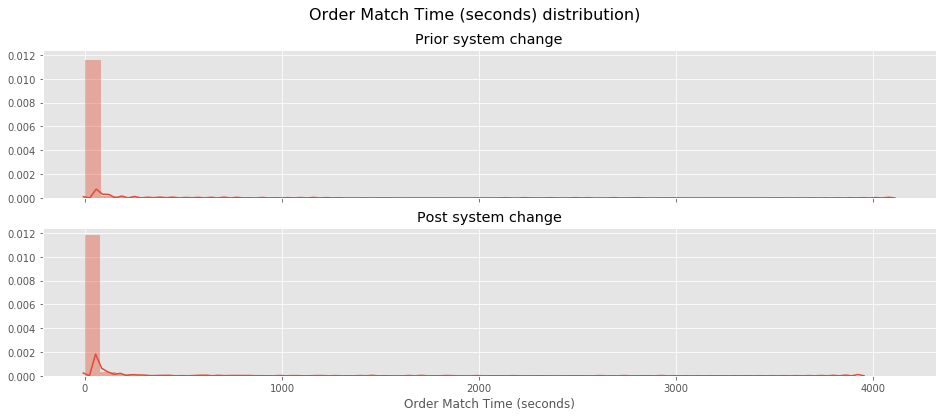

In [74]:
# Lets visualize the order match time distribution
fig, ax = plt.subplots(nrows=2,sharex='col',sharey=True, figsize=(16,6))
sns.distplot(response_prior['Duration'], ax=ax[0])
sns.distplot(response_post['Duration'], ax=ax[1])
ax[0].set_xlabel('')
ax[1].set_xlabel('Order Match Time (seconds)',fontsize=12)
ax[0].set_title('Prior system change')
ax[1].set_title('Post system change')
fig.suptitle('Order Match Time (seconds) distribution)', fontsize=16)
plt.show()

#### Since the plots are highly skewed, lets plot the order match time <= 90th percentile

In [75]:
# First we create dataframes for both the prior and post set of records
response_prior90 = response_prior[response_prior['Duration']<=np.percentile(response_prior['Duration'], 90)].reset_index(drop=True)
response_post90 = response_post[response_post['Duration']<=np.percentile(response_post['Duration'], 90)].reset_index(drop=True)

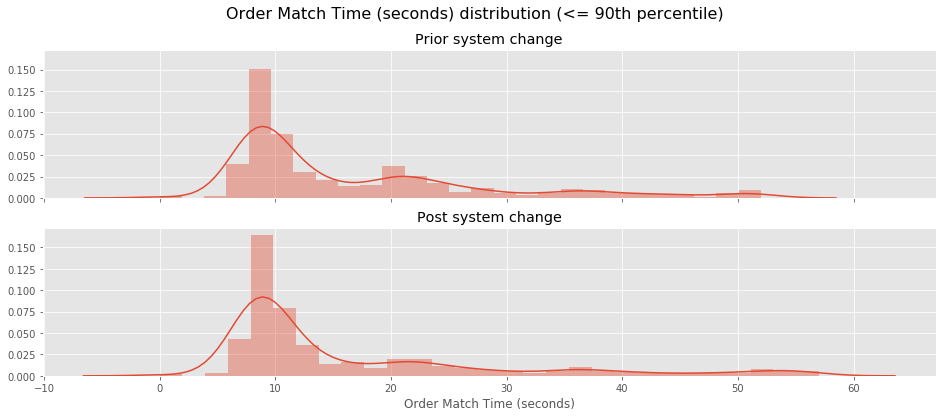

In [76]:
fig, ax = plt.subplots(nrows=2,sharex='col',sharey=True, figsize=(16,6))
sns.distplot(response_prior90['Duration'], ax=ax[0])
sns.distplot(response_post90['Duration'], ax=ax[1])
ax[0].set_xlabel('')
ax[1].set_xlabel('Order Match Time (seconds)',fontsize=12)
ax[0].set_title('Prior system change')
ax[1].set_title('Post system change')
fig.suptitle('Order Match Time (seconds) distribution (<= 90th percentile)', fontsize=16)
plt.show()

#### The histograms are quite similar and are not normally distributed. Now let's plot a boxplot to better understand the distribution

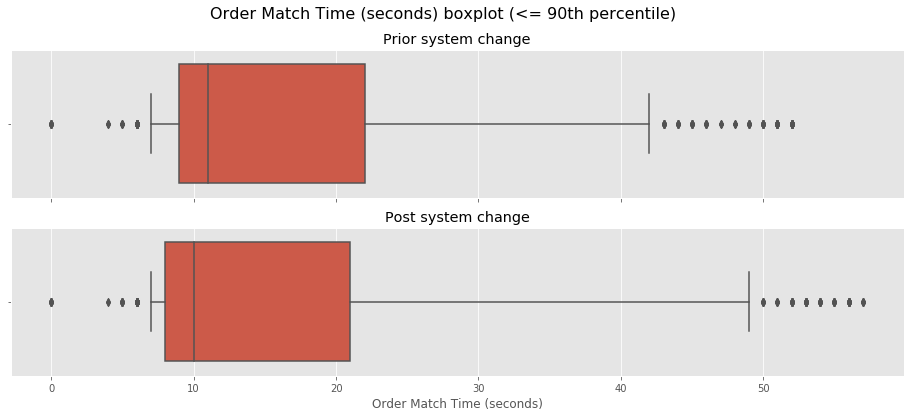

In [77]:
fig, ax = plt.subplots(nrows=2,sharex='col',sharey=True, figsize=(16,6))
sns.boxplot(x=response_prior90['Duration'], whis=[5, 95], ax=ax[0])
sns.boxplot(x=response_post90['Duration'], whis=[5, 95], ax=ax[1])
ax[0].set_xlabel('')
ax[1].set_xlabel('Order Match Time (seconds)',fontsize=12)
ax[0].set_title('Prior system change')
ax[1].set_title('Post system change')
fig.suptitle('Order Match Time (seconds) boxplot (<= 90th percentile)', fontsize=16)
plt.show()

#### From the boxplot we can tell there is a shift of the distribution, the 25% percentile, median and 75% percentile shifted lower! So there seemed to be improvement from the system change! There were more large order match time after post system change though. To check how confident we are about the shifting of distribution. let's perform some test statistics!

#### Since the distributions are not normal, we will have to perform a non-parametric test on the dataset

#### We will perform the Mann-Whitney U Test to check the shift of direction with the following assumptions

#### 1) All the observations are independent of each other

#### 2) Dependent variables (Order match time) are ordinal

#### 3) Independent variables (System change) are categorical

#### 4) Data is not normally distributed, two distributions have the same shape

#### Null hypothesis: Both distributions are the same

#### Alternative hypothesis: The post change set has less distribution than the prior change set

#### Alpha = 5%

#### Decision rule: Reject null hypothesis if p-value is lower than 5%

In [78]:
st.mannwhitneyu(response_prior['Duration'], response_post['Duration'], alternative='greater')

MannwhitneyuResult(statistic=3220515.0, pvalue=0.024212376887505993)

#### Here we get a p-value of 0.024 which is considerably smaller than 0.05. Hence we can reject the null hypothesis i.e. both the distributions are the same, with a confidence of 95%.

#### Thus it can be said than the change implemented on Order Allocation System has improved the response time of drivers after orders are placed

# Question 2) Any additional insights or observations you think are worth noting?

#### Lets perform some EDA to get a better understanding of the orders that are being placed

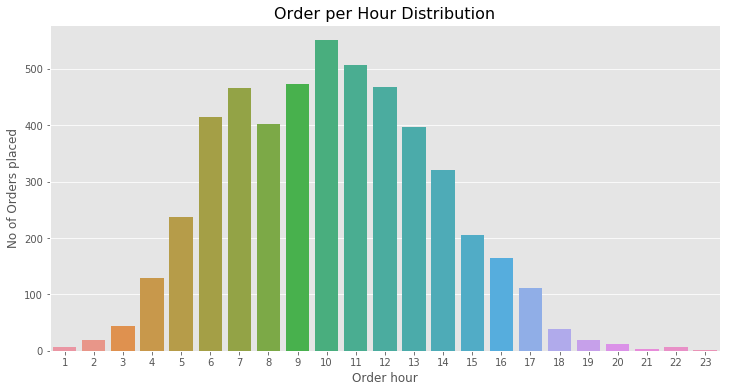

In [79]:
# First we will plot a distribution of the hours of the day during which the orders are being placed
plt.figure(figsize=(12,6))
sns.countplot(x="Order hour", data=response_df)
plt.title('Order per Hour Distribution', fontsize=16)
plt.xlabel('Order hour', fontsize=12)
plt.xticks(rotation='horizontal')
plt.ylabel('No of Orders placed',fontsize=12)
plt.show()

#### From the above distribution it can be noted than the highest number of orders are being placed from 06:00 to 14:00 hours i.e. from early morning to the afternoon. While, there is no significant amount of orders being placed at night

In [80]:
# Now lets check which are the busiest days of the week where orders are being placed
df = pd.DataFrame()
df['Day of week'] = range(1,8)
df['Orders Placed'] = response_df['Order day of week'].value_counts()
df

,Day of week,Orders Placed
0,1,1160
1,2,624
2,3,610
3,4,634
4,5,418
5,6,438
6,7,1116


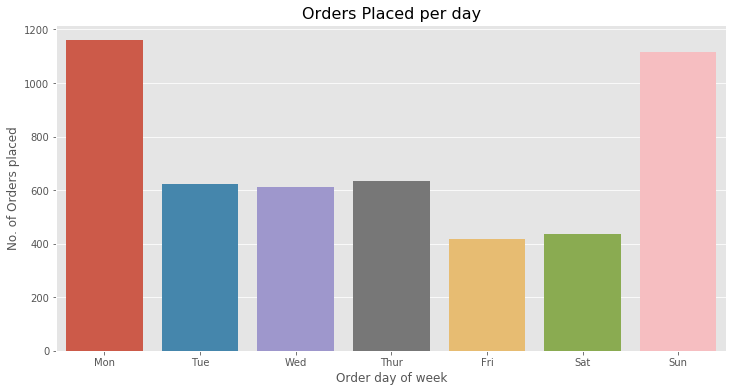

In [81]:
day_names = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
plt.figure(figsize=(12,6))
sns.barplot(x='Day of week', y='Orders Placed', data=df)
plt.title('Orders Placed per day', fontsize=16)
plt.xlabel('Order day of week', fontsize=12)
plt.xticks(range(0,7), day_names, rotation='horizontal')
plt.ylabel('No. of Orders placed',fontsize=12)
plt.show()

#### We see that the highest numbers of orders are placed on Sundays and Mondays, while Fridays and Saturdays see the least amount of orders being placed. This can help us better understand customer behavior patterns later

#### Now lets check if there is any difference in the duration of response time on the days of the week prior to and post the change in allocation system

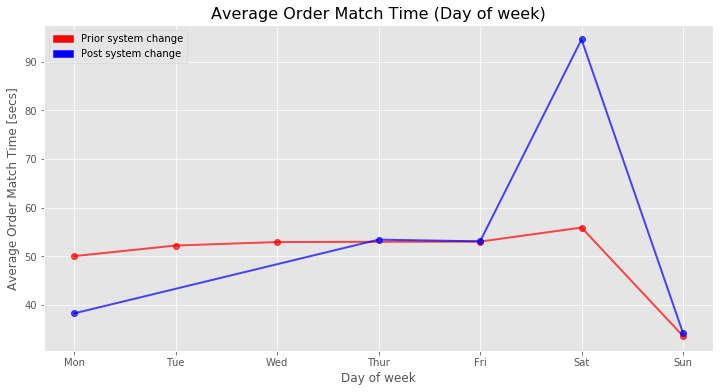

In [82]:
plt.figure(figsize=(12,6))
plt.plot(response_prior.groupby('Order day of week')['Duration'].mean(), 'ro-', lw=2, alpha=0.7)
plt.plot(response_post.groupby('Order day of week')['Duration'].mean(), 'bo-', lw=2, alpha=0.7)

plt.xticks(range(0, 7), day_names) #set name of label

red_patch = mpatches.Patch(color='red', label='Prior system change')
blue_patch = mpatches.Patch(color='blue', label='Post system change')
plt.legend(handles=[red_patch, blue_patch])

plt.xlabel('Day of week', fontsize=12)
plt.ylabel('Average Order Match Time [secs]')
plt.title('Average Order Match Time (Day of week)', fontsize=16)
plt.show()

#### From the above graph we can deduce that the average match time for orders on the busiest days of the week has reduced after the change was implemented on the Order Allocation System. However, the average match time for Saturdays have drastically increased. This can be due to some unknown external factors like driver availability etc.

# Question 3) Any observations regarding the testing process or     environment? How would you improve or redesign this experiment?

#### In order to improve the experiment we can implement A/B testing, where two sets of customers are allowed to use the application in two different versions - One with the changes in the order allocation system and one without the changes, at the same time. This will be a parallel testing environment that will have the same set of external variables for both sets of customers and will thus give us a more statistically accurate result.